In [41]:
#Using smth means: pre-compile and load smth as a package.
using Pkg;
#Set the Gurobi path
ENV["GUROBI_HOME"] = "/Library/gurobi1002/macos_universal2/"
#For first timers (comment after): compile Gurobi with the given path
Pkg.build("Gurobi")
#Add the packages that may not be installed.
Pkg.add(["Latexify", "Polyhedra", "Plots", "Makie", "CDDLib", "JuMP", "Gurobi", "AbstractPlotting"])
#Load the packages
using JuMP, Latexify, Gurobi, LinearAlgebra, Polyhedra, CDDLib, Plots, SparseArrays, Makie, AbstractPlotting

display("Initialization done! All set :-)")

    Building Gurobi → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/1eeff1b016fae36fbd4524c40b6ebff44748c811/build.log`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


"Initialization done! All set :-)"

In [42]:
using CSV
using DataFrames
using Distances
using Statistics
using Plots

In [43]:
file_path_1 = "cities_small.csv"
file_path_2 = "packages_small.csv"
df_cities = CSV.File(file_path_1) |> DataFrame
df_packages = CSV.File(file_path_2) |> DataFrame

Row,origin,destination,packages
,Int64,Int64,Int64
1,2,15,2878
2,2,6,3745
3,2,3,2973
4,2,5,4868
5,2,8,2796
6,2,13,3910
7,2,12,2782
8,2,1,2423
9,2,4,2764


In [104]:
latitudes = df_cities.lat
longitudes = df_cities.lon
N = length(latitudes)
alpha = 0.75
distance_matrix = Matrix{Float64}(undef, N, N)
for i in 1:N
    for j in 1:N
        distance_matrix[i, j] = euclidean([latitudes[i], longitudes[i]], [latitudes[j], longitudes[j]])
    end
end
package_matrix = zeros(Int, N, N)
for row in eachrow(df_packages)
    origin = row.origin + 1
    destination = row.destination + 1
    packages = row.packages
    package_matrix[origin, destination] = packages
end
d = distance_matrix
f = package_matrix
origin_flow = [sum(row) for row in eachrow(package_matrix)]
destination_flow = [sum(col) for col in eachcol(package_matrix)]

17-element Vector{Int64}:
 30094
 37124
 51162
 42805
 43651
 40630
 26295
 31565
 27058
 25563
 53075
 24420
 29320
 29714
 27833
 28158
 38258

In [178]:
using Gurobi, JuMP
m = Model(Gurobi.Optimizer)
set_optimizer_attribute(m, "OutputFlag", 1)
K = 2

# variables
@variable(m, x[1:N, 1:N], Bin) 
@variable(m, y[1:N, 1:N, 1:N], Int)

# objective function
@objective(m, Min, sum(x[i,k]*origin_flow[i]*d[i,k] for i in 1:N, k in 1:N) + sum(d[k,s]*alpha*y[i,k,s] 
        for i in 1:N, k in 1:N, s in 1:N) + sum(d[k,i]*destination_flow[i]*x[i,k] for i in 1:N, k in 1:N))

# Constraints
for i in 1:N
    @constraint(m, sum(x[i,k] for k in 1:N) == 1)
    for k in 1:N
        @constraint(m, x[i,k] <= x[k,k])
        @constraint(m, sum(y[i,k,s] for s in 1:N) - sum(y[i,s,k] for s in 1:N) == 
            origin_flow[i]*x[i,k] - sum(f[i,j]*x[j,k] for j in 1:N))
        @constraint(m, sum(y[i,k,s] for s in 1:N if s != k) <= origin_flow[i]*x[i,k])
        for s in 1:N
            @constraint(m, y[i,k,s] >= 0)
        end
    end
end

@constraint(m, sum(x[i,i] for i in 1:N) == K)

# solve
optimize!(m)

x_value = JuMP.value.(x)
hub = []

for i in 1:N
    if x_value[i,i] > 0.5
        println("city $(i-1) is selected as a hub.")
        push!(hub,i)
    end
end
println(hub)
value.(x)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-02
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5798 rows, 5202 columns and 24684 nonzeros
Model fingerprint: 0x65469342
Variable types: 0 continuous, 5202 integer (289 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+04]
  Objective range  [2e-01, 4e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 4947 rows and 561 columns
Presolve time: 0.09s
Presolved: 851 rows, 4641 columns, 18666 nonzeros
Variable types: 0 continuous, 4641 integer (289 binary)
Found heuristic solution: objective 2.600094e+07
Found heuristic solution: objective 2.042618e+07

Root relaxation: objective 1.318341e+07, 851 iterations, 0.04 seconds (0.04 work units)

    Nodes    |    Current Node    |     Objectiv

17×17 Matrix{Float64}:
 -0.0   0.0  -0.0   0.0  -0.0  -0.0  …  -0.0  -0.0  -0.0  -0.0  -0.0   1.0
 -0.0   0.0  -0.0   0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0   1.0
 -0.0  -0.0   1.0  -0.0  -0.0  -0.0     -0.0   0.0  -0.0  -0.0  -0.0  -0.0
 -0.0   0.0  -0.0  -0.0  -0.0  -0.0     -0.0   0.0  -0.0  -0.0  -0.0   1.0
 -0.0   0.0  -0.0   0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0   1.0
 -0.0  -0.0   1.0   0.0  -0.0  -0.0  …  -0.0   0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0   1.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0   1.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0   1.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0   1.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0   1.0  -0.0  -0.0  -0.0  …  -0.0   0.0  -0.0  -0.0  -0.0  -0.0
 -0.0   0.0  -0.0   0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0   1.0
 -0.0  -0.0   1.0   0.0  -0.0  -0.0     -0.0   0.0  -0.0  -0.0  -0.0  -0.0
 -

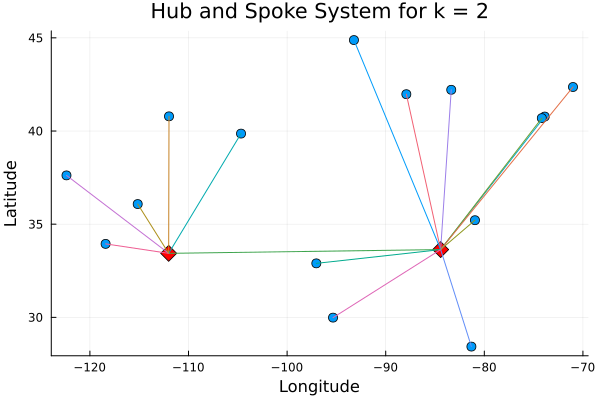

In [70]:
lats = df_cities.lat
lons = df_cities.lon
ids = df_cities.id
p = Plots.plot(;legend=false, xlabel="Longitude", ylabel="Latitude", title="Hub and Spoke System for k = 2")
Plots.scatter!(p, lons, lats, label="", markersize=5, legend=:topright)
hub_lat = [lats[3],lats[17]]
hub_lon = [lons[3],lons[17]]
Plots.scatter!(hub_lon, hub_lat, label=false, marker=:diamond, color=:red, markersize=8)
Plots.plot!([lons[3], lons[17]], [lats[3], lats[17]], label="")
hub17 = [1,2,4,5,12]
for i in hub17
    Plots.plot!([lons[i], lons[17]], [lats[i], lats[17]], label="")
end
hub3 = [6,7,8,9,10,11,13,14,15,16]
for i in hub3
    Plots.plot!([lons[i], lons[3]], [lats[i], lats[3]], label="")
end
display(p)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-02
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5798 rows, 5202 columns and 24684 nonzeros
Model fingerprint: 0xdafe868d
Variable types: 0 continuous, 5202 integer (289 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+04]
  Objective range  [2e-01, 4e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3.221802e+07
Presolve removed 5798 rows and 5202 columns
Presolve time: 0.03s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.04 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 1.83276e+07 3.2218e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.832756910952e+07, best bou

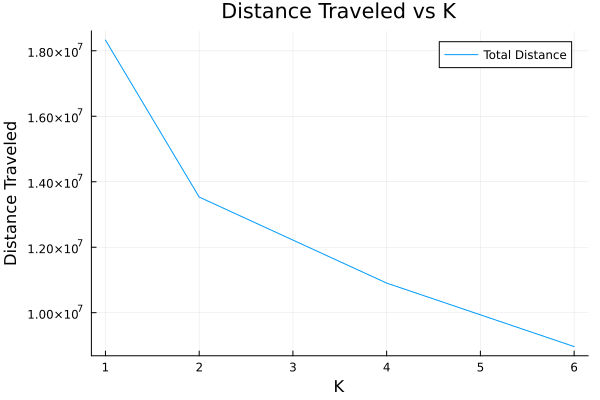

In [54]:
using Plots
function solve_model(K)
    m = Model(Gurobi.Optimizer)
    set_optimizer_attribute(m, "OutputFlag", 1)
    N = length(latitudes)
    K = K
    d = distance_matrix
    f = package_matrix
    alpha = 0.75
    # variables
    @variable(m, x[1:N, 1:N], Bin) 
    @variable(m, y[1:N, 1:N, 1:N], Int)

    # objective function
    @objective(m, Min, sum(x[i,k]*origin_flow[i]*d[i,k] for i in 1:N, k in 1:N) + sum(d[k,s]*alpha*y[i,k,s] 
            for i in 1:N, k in 1:N, s in 1:N) + sum(d[k,i]*destination_flow[i]*x[i,k] for i in 1:N, k in 1:N))

    # Constraints
    for i in 1:N
        @constraint(m, sum(x[i,k] for k in 1:N) == 1)
        for k in 1:N
            @constraint(m, x[i,k] <= x[k,k])
            @constraint(m, sum(y[i,k,s] for s in 1:N) - sum(y[i,s,k] for s in 1:N) == 
                origin_flow[i]*x[i,k] - sum(f[i,j]*x[j,k] for j in 1:N))
            @constraint(m, sum(y[i,k,s] for s in 1:N if s != k) <= origin_flow[i]*x[i,k])
            for s in 1:N
                @constraint(m, y[i,k,s] >= 0)
            end
        end
    end

    @constraint(m, sum(x[i,i] for i in 1:N) == K)

    # solve
    optimize!(m)
    return objective_value(m)
end

K_values = [1, 2, 4, 6]
results = [solve_model(K) for K in K_values]
Plots.plot(K_values, results, label="Total Distance", xlabel="K", ylabel="Distance Traveled", title="Distance Traveled vs K")


Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-02
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5798 rows, 5202 columns and 24684 nonzeros
Model fingerprint: 0xdafe868d
Variable types: 0 continuous, 5202 integer (289 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+04]
  Objective range  [2e-01, 4e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3.221802e+07
Presolve removed 5798 rows and 5202 columns
Presolve time: 0.03s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.04 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 1.83276e+07 3.2218e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.832756910952e+07, best bou

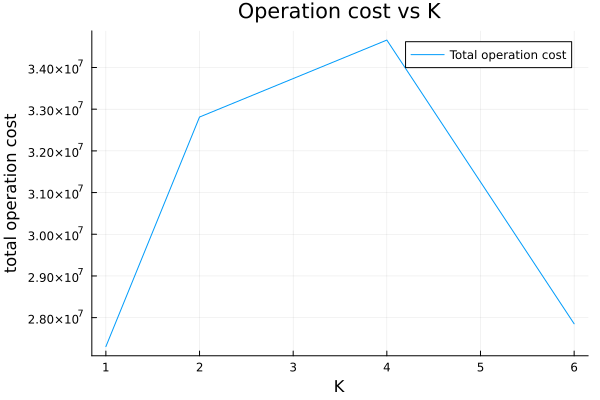

In [203]:
function solve_model_cost(K)
    m = Model(Gurobi.Optimizer)
    set_optimizer_attribute(m, "OutputFlag", 1)
    N = length(latitudes)
    K = K
    d = distance_matrix
    f = package_matrix
    alpha = 0.75
    # variables
    @variable(m, x[1:N, 1:N], Bin) 
    @variable(m, y[1:N, 1:N, 1:N], Int)

    # objective function
    @objective(m, Min, sum(x[i,k]*origin_flow[i]*d[i,k] for i in 1:N, k in 1:N) + sum(d[k,s]*alpha*y[i,k,s] 
            for i in 1:N, k in 1:N, s in 1:N) + sum(d[k,i]*destination_flow[i]*x[i,k] for i in 1:N, k in 1:N))

    # Constraints
    for i in 1:N
        @constraint(m, sum(x[i,k] for k in 1:N) == 1)
        for k in 1:N
            @constraint(m, x[i,k] <= x[k,k])
            @constraint(m, sum(y[i,k,s] for s in 1:N) - sum(y[i,s,k] for s in 1:N) == 
                origin_flow[i]*x[i,k] - sum(f[i,j]*x[j,k] for j in 1:N))
            @constraint(m, sum(y[i,k,s] for s in 1:N if s != k) <= origin_flow[i]*x[i,k])
            for s in 1:N
                @constraint(m, y[i,k,s] >= 0)
            end
        end
    end

    @constraint(m, sum(x[i,i] for i in 1:N) == K)

    # solve
    optimize!(m)
    hub1 = []
    for i in 1:N
        if value.(x[i,i]) == 1.0
            println("city $(i-1) is selected as a hub.")
            push!(hub1,i)
        end
    end
    println(hub1)
    cost = 0
    for i in 1:17
        for j in 1:17
            if !in(j,hub1)
                for z in hub1
                    if value.(x[i,z]) == 1
                        if value.(x[j,z]) == 1
                            cost += f[i,j]
                        else
                            cost += 2*f[i,j]
                        end
                    end
                end
            end
        end
    end         
    return cost * 50
end

K_values = [1, 2, 4, 6]
results = [solve_model_cost(K) for K in K_values]
Plots.plot(K_values, results, label="Total operation cost", xlabel="K", ylabel="total operation cost", title="Operation cost vs K")

In [211]:
using Plots
function solve_model_overheadcost(c)
    m = Model(Gurobi.Optimizer)
    set_optimizer_attribute(m, "OutputFlag", 1)
    N = length(latitudes)
    K = 2
    d = distance_matrix
    f = package_matrix
    alpha = 0.75
    c = c
    hub1 = []
    # variables
    @variable(m, x[1:N, 1:N], Bin) 
    @variable(m, y[1:N, 1:N, 1:N], Int)

    # objective function
    @objective(m, Min, sum(x[i,k]*origin_flow[i]*((d[i,k])+c) for i in 1:N, k in 1:N) + sum((d[k,s]*alpha+c)*y[i,k,s] 
            for i in 1:N, k in 1:N, s in 1:N) + sum((d[k,i]+c)*(destination_flow[i])*x[i,k] for i in 1:N, k in 1:N))


    # Constraints
    for i in 1:N
        @constraint(m, sum(x[i,k] for k in 1:N) == 1)
        for k in 1:N
            @constraint(m, x[i,k] <= x[k,k])
            @constraint(m, sum(y[i,k,s] for s in 1:N) - sum(y[i,s,k] for s in 1:N) == 
                origin_flow[i]*x[i,k] - sum(f[i,j]*x[j,k] for j in 1:N))
            @constraint(m, sum(y[i,k,s] for s in 1:N if s != k) <= origin_flow[i]*x[i,k])
            for s in 1:N
                @constraint(m, y[i,k,s] >= 0)
            end
        end
    end

    @constraint(m, sum(x[i,i] for i in 1:N) == K)
    
    @constraint(m, c >= 0)

    # solve
    optimize!(m)
    for i in 1:N
        if value.(x[i,i]) == 1.0
            println("city $(i-1) is selected as a hub.")
            push!(hub1,i)
        end
    end
    return (objective_value(m))
end

c_values = [5, 10, 20, 40]
results = [solve_model_overheadcost(c) for c in c_values]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-02
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 5799 rows, 5202 columns and 24684 nonzeros
Model fingerprint: 0x8f053014
Variable types: 0 continuous, 5202 integer (289 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+04]
  Objective range  [5e+00, 5e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 4948 rows and 561 columns
Presolve time: 0.09s
Presolved: 851 rows, 4641 columns, 18666 nonzeros
Variable types: 0 continuous, 4641 integer (289 binary)
Found heuristic solution: objective 2.883183e+07
Found heuristic solution: objective 2.773935e+07

Root relaxation: objective 1.987380e+07, 839 iterations, 0.06 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objectiv

4-element Vector{Float64}:
 2.0347095148177847e7
 2.7162850148177847e7
 4.079436014817785e7
 6.701279683985841e7

The example of the hub-and-spoke model from FreshFarm’s network optimization exhibit certain practicalities and advantages of the model:
● Cost-Effectiveness: A hub-and-spoke model can be more cost-effective when compared to a direct point-to-point network. Although a direct point-to-point system may initially seem cheaper due to reduced travel distance, it overlooks the accumulated operational overhead costs at each stop. Each city-to-city transfer incurs costs from labor, potential delays, and administrative tasks. On the other hand, the hub-and-spoke model is able to consolidate these operational activities at fewer locations (hubs). As a result, the system can become more cost-effective despite longer travel distances. The cost savings come from economies of scale in operations—processing large numbers of packages at a central point is cheaper per unit than processing them at numerous smaller points. Moreover, the hub-and-spoke model reduces the number of times a package is handled, which makes it more efficient.
● Complexity: A direct delivery network would increase the complexity of the network, as each new city added would create a new direct route to manage. In contrast, the hub-and-spoke system simplifies this by consolidating routes through central hubs, which reduces the number of decisions and transactions required to manage the network. As a result, the model may reduce potential logistics and administrative costs.
● Inventory management: When considering the hub-and-spoke distribution model, particularly for a company like FreshFarm that deals with perishable goods, inventory management becomes vital. The model's centralized nature provides significant visibility over inventory as all products pass through the hub. This allows for improved forecasting and stock allocation in line with fluctuating demand patterns. Additionally, the consolidation of inventory means that each spoke does not need to maintain extensive stock levels, which translates to cost savings on several fronts.
● Network Design and Efficiency: The hub-and-spoke model is able to determine the number of hub cities in order to optimize the network design. When considering both distance-related costs and handling costs at hubs, too few hubs could overload the system and increase travel time for some packages, while too many could inflate costs unnecessarily. Thus, determining the number of hubs becomes extremely critical in optimizing the total system. Moreover, the hub-and-spoke model can determine the location of the hub cities in order to optimize the system network, which is shown in question 4. When we set our c_values (cost per package) to different values, we observed that the optimal hub cities changed as c_values increased. When the c_values were set to be 5, 10, and 20, the optimal hub cities were city 2 and city 16. However, when the c_value increased to 40, the optimal hub cities changed to city 5 and city 11. From question 4, we were able to observe that the hub-and-spoke model can help to determine the optimal number and location of hub cities in order to yield the best result.
In conclusion, the hub-and-spoke model presents a robust framework for FreshFarm's distribution network, striking a balance between efficiency and cost-effectiveness.